In [1]:
"""
g_wave_setup.ipynb

Created by Chris Stevens 2023
Copyright (c) 2023 University of Canterbury. All rights reserved.
"""

################################################################################
# Import required libraries
################################################################################

import numpy as np
import h5py
from mpi4py import MPI

from coffee import ibvp, actions, solvers, grid
from coffee.diffop.sbp import sbp

import g_wave
import g_wave_plotter_2 as gw_plotter

np.set_printoptions(threshold=np.inf, precision=16)

In [2]:
################################################################################
# Simulation parameters
################################################################################

N      = 400   # Number of sptial intervals (number of points  - 1)
a      = 32.   # Amplitude of the waves
A      = 4.    # A function related to the scale of the spatial direction
pl     = [0.]  # An array of polarisations for the wave(s) travelling rightward
pr     = [0.]  # An array of polarisations for the wave(s) travelling leftward

tau    = 1.    # A parameter for the SAT method (greater than or equal to 1)
CFL    = 0.2   # The Courant-Friedrichs-Lewy number (less than or equal to 1)

zstart = -1.   # Lower bound for grid
zstop  = 1.    # Lower bound for grid
tstart = 0.    # Start of simulation
tstop  = 1.    # Stop of simulation

store_output = True       # Output HDF5 data
filename     = 'sim.hdf'  # Name of HDF5 file

display_output = True     # Display animation during simulation

In [3]:
################################################################################
# Instantiate the operator which approximates spatial derivatives
################################################################################

# diffop = sbp.D21_CNG(sbp.BOUNDARY_TYPE_GHOST_POINTS)
diffop = sbp.D43_Strand(sbp.BOUNDARY_TYPE_GHOST_POINTS)

In [4]:
################################################################################
# MPI setup
################################################################################

dims = MPI.Compute_dims(MPI.COMM_WORLD.size, [0])                                    
periods = [0]                                                                        
reorder = True                                                                       
mpi_comm = MPI.COMM_WORLD.Create_cart(dims, periods=periods, reorder=reorder)        


In [5]:
################################################################################
# Grid setup
################################################################################

ghost_points = (diffop.ghost_points(),)
internal_points = (diffop.internal_points(),)
b_data = grid.MPIBoundary(
    ghost_points, 
    internal_points, 
    mpi_comm=mpi_comm, 
    number_of_dimensions=1
)

grid = grid.UniformCart(
        (N,), 
        [[zstart,zstop]],
        comparison = N,
        mpi_comm = mpi_comm,
        boundary_data=b_data
    )

global_z = np.linspace(zstart, zstop, N+1)

In [6]:
################################################################################
# Instantiate the system
################################################################################

system = g_wave.G_wave(\
        diffop, tau, global_z, 
        CFL = CFL, 
        amplitude = a,
        A=A,
        pl = pl, pr = pr
        )

In [7]:
################################################################################
# Instantiate the solver
################################################################################

solver = solvers.RungeKutta4(system)
maxIteration = 10000000

In [8]:
################################################################################
# Details for file output when necessary
################################################################################

if store_output and mpi_comm.rank == 0:
    hdf_file = h5py.File(filename, "w")
    output_actions = [
    actions.SimOutput.Data(),
    actions.SimOutput.Times(),
    actions.SimOutput.Domains()
    ]

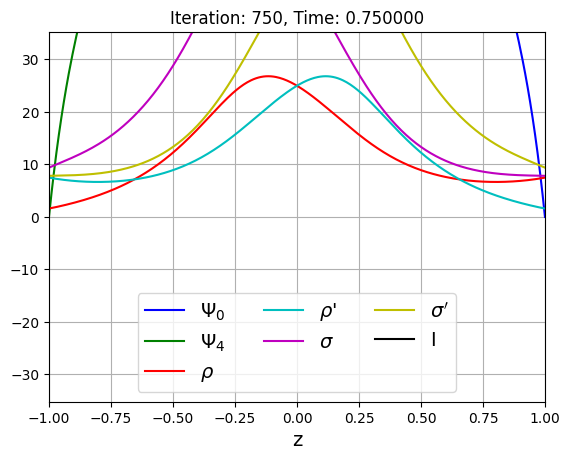

/mnt/Data/GW_Workshop/Lab2/g_wave.py:131: RuntimeWarning: overflow encountered in multiply
  dpsi0 = (-6.*sigma*psi2 + 2.*psi0*(-2.*(F + mu + rho) + rhop) - \
/mnt/Data/GW_Workshop/Lab2/g_wave.py:131: RuntimeWarning: invalid value encountered in add
  dpsi0 = (-6.*sigma*psi2 + 2.*psi0*(-2.*(F + mu + rho) + rhop) - \
/mnt/Data/GW_Workshop/Lab2/g_wave.py:132: RuntimeWarning: overflow encountered in multiply
  rt2*A*dzpsi0) / (rt2*(B - 1.))
/mnt/Data/GW_Workshop/Lab2/g_wave.py:131: RuntimeWarning: invalid value encountered in divide
  dpsi0 = (-6.*sigma*psi2 + 2.*psi0*(-2.*(F + mu + rho) + rhop) - \
/mnt/Data/GW_Workshop/Lab2/g_wave.py:133: RuntimeWarning: overflow encountered in multiply
  dpsi4 = (-2.*psi4*(2.*F - 2.*mu + rho - 2.*rhop) + \
/mnt/Data/GW_Workshop/Lab2/g_wave.py:134: RuntimeWarning: overflow encountered in multiply
  6.*psi2*sigmap - rt2*A*dzpsi4) / (rt2*(B + 1.))
/mnt/Data/GW_Workshop/Lab2/g_wave.py:133: RuntimeWarning: invalid value encountered in add
  dpsi4 = (-2.*psi

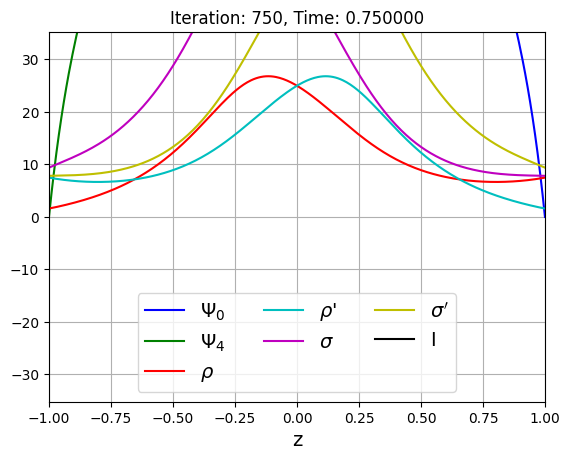

In [9]:
################################################################################
# Instantiate the IBVP problem
################################################################################
   
actionList = []
if store_output and mpi_comm.rank == 0:
    actionList += [actions.SimOutput(\
        hdf_file,\
        solver, \
        system, \
        grid, \
        output_actions,\
        overwrite = True,\
        name = grid.name,\
        cmp_ = grid.comparison\
        )];
if display_output and mpi_comm.rank == 0:
    # plot_range = (-a*0.1, a*1.1)
    plot_range = (-a*1.1, a*1.1)
    actionList += [gw_plotter.Plotter(
        system,
        frequency = 10, 
        xlim = (zstart, zstop),
        ylim = plot_range, 
        findex = (7,8,3,4,5,6),
        labels = (r"$\Psi_0$",r"$\Psi_4$",r"$\rho$",r"$\rho$'", \
                    r"$\sigma$",r"$\sigma'$"),
        delay = 0.0001
    )]
problem = ibvp.IBVP(solver, system, grid = grid,\
        maxIteration = 1000000, action = actionList,\
        minTimestep = 1e-6)

################################################################################
# Run the simulation
################################################################################

problem.run(tstart, tstop)

if store_output and mpi_comm.rank == 0:
    hdf_file.close()